# Prediction of Singapore's housing price using simple regression based models
## Exploratory Data Analysis notebook

This project is about the prediction of resale price of a house located in singapore, using simple regression model.   
This notebook is only for the purpose of doing Exploratory Data Analysis (EDA).

content:  
1. [Problem Statement](#Problem-Statement)
2. [Data Import](#Data-Import)
3. [Missing Values](#Missing-Values)
4. [Data Distribution](#Data-Distribution)
5. [Outliers](#Outliers)
6. [Summary Statistics](#Summary-Statistics)
7. [Evaluation based on EDA](#Evaluation-based-on-EDA)

## Problem Statement 

The goal of this project is to build a regression model, using data contained in the [datasets](../datasets) folder. The model should be able to make an accurate prediction of the resale price (`resale_price`) of the house, for every house id (`Id`) that appeared in the [test set](../datasets/test.csv).  
Success will be evaluated based on common evaluation metrics such as Mean Absolute Error (MAE) and Mean Square Error (MSE), apart from scores.

Motivation:  
While this is a toy project for the purpose of learning, it shows the importance of prediction models.  
House owners who are looking to sale their property, property agents, those seeking to purchase a house, all stand to benefit from this model.  

## Data Import

Here, the neccessary libraries, dependencies and data are imported.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 100
pd.options.display.max_columns = 80

If simply use `.read_csv()` method from Pandas, a warning will appear.  

`DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.`  
`train = pd.read_csv('../datasets/train.csv')`   

In [2]:
sample = pd.read_csv('../datasets/sample_sub_reg.csv')
train = pd.read_csv('../datasets/train.csv')

/tmp/ipykernel_1225/3171447742.py:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../datasets/train.csv')


In [3]:
# check the shape of the data imported
train.shape

(150634, 78)

In [4]:
# Take a look at the column with warning
train.iloc[:,42].head()

0    382003
1    570153
2    651289
3    570232
4    760876
Name: postal, dtype: object

In [5]:
# From output above, the main dtpye is object. Upon checking (and guessing from convention), it is of str type.
# Check what is the total number of data points that is not in str datatype.
not_str = [x for x in train.iloc[:,42] if type(x) != str]
# Check what type can these data points be.
print(type(not_str[0]))
print(len(not_str))
# Check are there any more data types
not_int = [s for s in not_str if type(s) != int]
print(len(not_int))

<class 'int'>
35946
0


In [6]:
# Check are there any other types of data I have not considered.
is_str = [x for x in train.iloc[:,42] if type(x) == str]
len(is_str)

114688

In [7]:
# find the name of the column with problem
train.columns[42]

'postal'

## Missing Values

In [8]:
# While coding, I discovered that some of the 'postal' have 'NIL' in the entry
nil_lst = train['postal'].loc[train['postal'] == 'NIL']
print(len(nil_lst))
print(len(nil_lst)/150634*100)

33
0.021907404702789544


In [9]:
# # convert 'NIL' to None/ Nan type
# train.loc[train['postal'] == 'NIL'] = None

In [10]:
# # convert str to int
# train.postal = [int(x) if type(x) == str else x for x in train.iloc[:,42]]

In [11]:
# train['postal'].isnull().sum()

In [12]:
not_str = [x for x in train.iloc[:,42] if type(x) != str]
# Check what type can these data points be.
print(type(not_str[0]))
print(len(not_str))

<class 'int'>
35946


In [13]:
# 114688 + 35946 == 150634. There are only 2 data types in column 42. int and str.
# define function to convert all string to int. 

def convert_dtype(x):
    if (type(x) != int):
        try:
            return int(x)
        except:
            if x == 'NIL':
                return -1
    else:
        return x
train['postal']=train['postal'].apply(convert_dtype)

In [14]:
# It is VERY important to note that I have converted all 'NIL' to -1
# so I dont have to convert the datatype for postal code from float to int again later.
# -1 is selected because there's no postal code with -1.
train['postal'].isnull().sum()

0

In [15]:
# find percentage of data missing
train.isnull().sum()/150634*100

id                            0.000000
Tranc_YearMonth               0.000000
town                          0.000000
flat_type                     0.000000
block                         0.000000
street_name                   0.000000
storey_range                  0.000000
floor_area_sqm                0.000000
flat_model                    0.000000
lease_commence_date           0.000000
resale_price                  0.000000
Tranc_Year                    0.000000
Tranc_Month                   0.000000
mid_storey                    0.000000
lower                         0.000000
upper                         0.000000
mid                           0.000000
full_flat_type                0.000000
address                       0.000000
floor_area_sqft               0.000000
price_per_sqft                0.000000
hdb_age                       0.000000
max_floor_lvl                 0.000000
year_completed                0.000000
residential                   0.000000
commercial               

<AxesSubplot: >

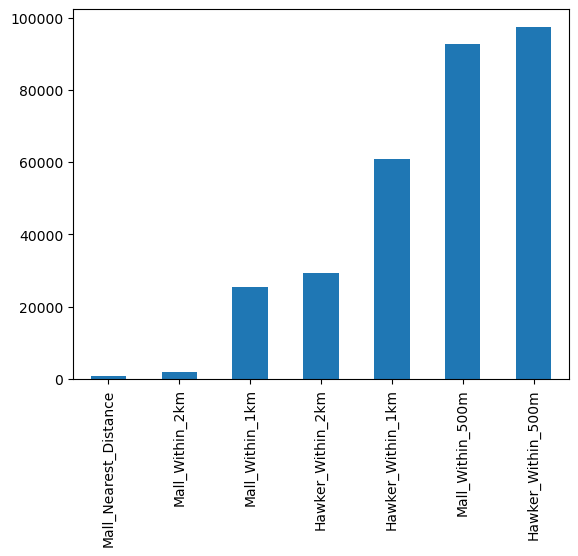

In [16]:
# Graphically

missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

There are a total of 7 + 1 features with `null` values in this dataset.  
The +1 is the postal code feature, where `null` was converted to `-1`. It have 33 entries, or 0.02% fo the data.  
The other 7 features with `null` are:  
|Fetures|Percentage|
|-------|----------|
|Mall_Nearest_Distance|       0.005503|  
|Mall_Within_500m|             0.615990|  
|Mall_Within_1km|              0.168793|  
|Mall_Within_2km|              0.012879|  
|Hawker_Within_500m|           0.646534|  
|Hawker_Within_1km|            0.404079|  
|Hawker_Within_2km|            0.193861|   

Since only 0.5% of `Mall_Nearest_Distance` is `null`, drop the `null` together with `postal` feature.   
Worst case senario, I am lose 0.52% of the data.  

As for the other 6 features, the `Mall_Nearest_Distance` and `Hawker_Nearest_Distance` already covered this information.  
The columns can be removed, as they are essentially the same information and they are obvious correlated. Which is not ideal for regression models.

In [17]:
train.drop(columns=['Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 
'Hawker_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km'], inplace=True)
train.shape

(150634, 72)

In [18]:
train.dropna(inplace=True)
train.shape

(149805, 72)

In [19]:
train = train[train['postal']>-1]
display(train.shape)
train.reset_index(drop=True, inplace=True)
display(train.head())

(149772, 72)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,price_per_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Hawker_Nearest_Distance,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,680000.0,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.760,701.928238,15,25,2005,Y,N,N,N,N,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.314299,103.872828,Kallang,1094.090418,154.753357,84,60,330.083069,Kallang,0,0,1.311540,103.871731,29.427395,Blk 3B,1.314433,103.872600,1138.633422,Geylang Methodist School,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,665000.0,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.320,475.230826,34,9,1987,Y,N,N,N,N,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.346086,103.855078,Bishan,866.941448,640.151925,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,BLK 151A MKT,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,838000.0,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.016,540.639580,24,16,1996,Y,N,N,N,N,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.343867,103.760535,Bukit Batok,1459.579948,1762.082341,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,Blk 289E,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,550000.0,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.692,496.080066,29,11,1990,Y,Y,N,N,N,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.358245,103.845504,Bishan,950.175199,726.215262,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,Opp Bishan Nth Shop Mall,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,298000.0,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.412,333.552717,34,4,1987,Y,N,N,N,N,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.414745,103.835532,Yishun,729.771895,1540.151439,45,0,412.343032,Khatib,0,0,1.417131,103.832692,129.422752,Blk 873,1.415424,103.836477,401.200584,Naval Base Primary School,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


With this, `null` values are removed and dataset is ready for EDA and further cleaning.  
Also note that there's `price_per_sqft` feature.   (=_=)|||    
However, this feature is not in GA Singapore's kaggle Data Dictionary.  
So it should be dropped before analysis. 

In [20]:
train.drop(columns=['price_per_sqft'], inplace=True)

In [21]:
train.max_floor_lvl.describe()

count    149772.000000
mean         15.107917
std           6.195142
min           2.000000
25%          12.000000
50%          13.000000
75%          16.000000
max          50.000000
Name: max_floor_lvl, dtype: float64

## Data Distribution

content:  
[Value to preict](#Value-to-predict)  
[Features used for prediction](#Features-used-for-prediction)  
[Numerical features](#Numerical-features)  
[Categorical features](#Categorical-features)   

### Value-to-predict

First, take a look at the distribution of feature to be predicted, `resale_price`.

In [22]:
train.resale_price.describe()

count    1.497720e+05
mean     4.486613e+05
std      1.432260e+05
min      1.500000e+05
25%      3.460000e+05
50%      4.200000e+05
75%      5.200000e+05
max      1.258000e+06
Name: resale_price, dtype: float64

We can see the resale price have a range of 150,000 to 1,258,000 SGD.   
Mean price is at 448,661.13 SGD. While median price is at 420,000 SGD. This shows a likely right skewness.  
This also shows most houses are still affordable back then.  
However, a good property can go up to 1.258 million SGD. That IS A LOT of money.  

<Figure size 1000x3000 with 0 Axes>

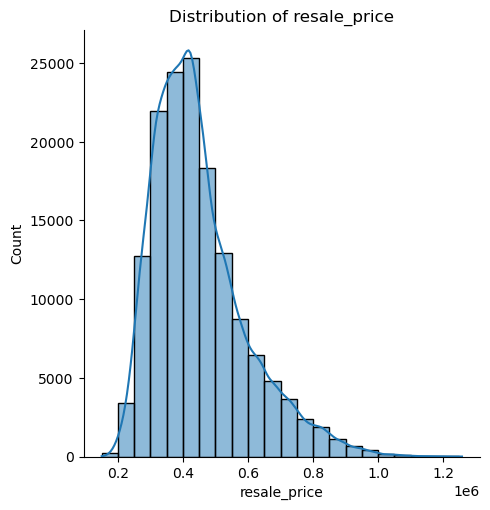

In [23]:
plt.figure(figsize = (10,30)); # plt.plot() is using plt to plot. plt.figure() is asking plt to give a canvas for drawing of anything
sns.displot(train.resale_price, kde=True, bins=list(range(150000, 1258000, 50000)))
plt.title('Distribution of resale_price');

Here, I am using a value of 50,000 per bin.  
This is becasue the default value and value of 10,000 per bin will both yeild very fine histograms which does not give a good overall representation of the distribution of the prices.   
At 50,000 per bin, that's roughly about 1 year's wage for many normal Singaporeans. This will give the rought shape of the distribution, with right ammount of details.  

From the figure above, we can see that model resale price is between 0.45 to 0.5 million SGD.   
Welp, the only thing I can say is get a girlfriend and buy early...   
Jokes aside, the defining features I can observe are:  
1. It is right skewed.
2. It deviates from normal distribution.
3. it is single peaked.

In [24]:
#skewness and kurtosis
print("Skewness: %f" % train.resale_price.skew())
print("Kurtosis: %f" % train.resale_price.kurt())

Skewness: 1.088377
Kurtosis: 1.338013


Note to self:  
Skewness:   
<img src="../img/wiki_skewness.png" width="200" height="100"></img>  
This image refers to the sample skewness, from Google.  
Skewness is a measure of the symmetry in a distribution.  A symmetrical dataset will have a skewness equal to 0.  So, a normal distribution will have a skewness of 0.   Skewness essentially measures the relative size of the two tails.   
Kurtosis:  
<img src="../img/goog_kurtosis.png" width="200" height="100"></img>  
This image refers to kurtosis of data, from Google.  
The kurtosis parameter is a measure of the combined weight of the tails relative to the rest of the distribution.  
Taken from [SPCforExcel website](https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics).

Essentially, these parameters are saying `resale_price` is not normally distributed and the center of the distribution still makes a large portion of the data.

### Features used for prediction 

Next, look at the data dictionary provided in GA Singapore's kaggle to check for the meaning od eacf feature.  
With this, I can get a rough sense of should the data be included in the first place.  
As we know, multicollinearity, where several independent variables in a model are correlated, will result in poorer model performance.  
Although tideous, this can be a good time to do a preliminary seiving for what variables to keep. 

|feature name| description| comment|
|---|---|---| 
|Tranc_YearMonth| year and month of the resale transaction, e.g. 2015-02|  categorical, should remove as other features covered this|
|town| HDB township where the flat is located, e.g. BUKIT MERAH | categorical, correlated to location features  
|flat_type| type of the resale flat unit, e.g. 3 ROOM | categorical   
|block| block number of the resale flat, e.g. 454 | categorical, correlated to location features like postal code  
|street_name|street name where the resale flat resides, e.g. TAMPINES ST 42 | categorical, correlated to location features  
|storey_range| floor level (range) of the resale flat unit, e.g. 07 TO 09 | categorical    
|floor_area_sqm| floor area of the resale flat unit in square metres  | numerical  
|flat_model| HDB model of the resale flat, e.g. Multi Generation  | categorical  
|lease_commence_date| commencement year of the flat unit's 99-year lease | numerical, becasue find how long the house is left with   
|Tranc_Year| year of resale transaction  | categorical  
|Tranc_Month| month of resale transaction  | categorical  
|mid_storey| median value of storey_range  | numerical? How tall of the blk is?  
|lower| lower value of storey_range |???  
|upper| upper value of storey_range |???   
|mid| middle value of storey_range | ???   
|full_flat_type| combination of flat_type and flat_model | should remove as other features covered it   
|address| combination of block and street_name| categorical, correalted to location    
|floor_area_sqft| floor area of the resale flat unit in square feet | numerical, correlated to floor_area_sqm, just keep 1   
|hdb_age| number of years from lease_commence_date to present year  | numerical, correlated to lease_commence_date, just keep 1  
|max_floor_lvl| highest floor of the resale flat  | ???   
|year_completed| year which construction was completed for resale flat | should remove as highly correlated to lease 
|residential| boolean value if resale flat has residential units in the same block  | categorical
|commercial| boolean value if resale flat has commercial units in the same block  | categorical
|market_hawker| boolean value if resale flat has a market or hawker centre in the same block  | categorical
|multistorey_carpark| boolean value if resale flat has a multistorey carpark in the same block  | categorical
|precinct_pavilion| boolean value if resale flat has a pavilion in the same block  | categorical
|total_dwelling_units| total number of residential dwelling units in the resale flat  | numerical
|1room_sold| number of 1-room residential units in the resale flat  | numerical
|2room_sold| number of 2-room residential units in the resale flat  |numerical
|3room_sold| number of 3-room residential units in the resale flat  |numerical
|4room_sold| number of 4-room residential units in the resale flat  |numerical
|5room_sold| number of 5-room residential units in the resale flat  | numerical
|exec_sold| number of executive type residential units in the resale flat block  |numerical
|multigen_sold| number of multi-generational type residential units in the resale flat block  |numerical
|studio_apartment_sold| number of studio apartment type residential units in the resale flat block  |numerical
|1room_rental| number of 1-room rental residential units in the resale flat block  |numerical
|2room_rental| number of 2-room rental residential units in the resale flat block  |numerical
|3room_rental| number of 3-room rental residential units in the resale flat block  |numerical
|other_room_rental| number of "other" type rental residential units in the resale flat block |numerical 
|postal| postal code of the resale flat block  |numerical, but actually it is doing categorical job
|Latitude| Latitude based on postal code |numerical 
|Longitude| Longitude based on postal code  |numerical
|planning_area| Government planning area that the flat is located  | categorical
|Mall_Nearest_Distance| distance (in metres) to the nearest mall  |numerical
|Mall_Within_500m| number of malls within 500 metres  |dropped
|Mall_Within_1km| number of malls within 1 kilometre  |dropped
|Mall_Within_2km| number of malls within 2 kilometres  |dropped
|Hawker_Nearest_Distance| distance (in metres) to the nearest hawker centre  | numerical
|Hawker_Within_500m| number of hawker centres within 500 metres  |dropped
|Hawker_Within_1km| number of hawker centres within 1 kilometre  |dropped
|Hawker_Within_2km| number of hawker centres within 2 kilometres  |dropped
|hawker_food_stalls| number of hawker food stalls in the nearest hawker centre  | numerical
|hawker_market_stalls| number of hawker and market stalls in the nearest hawker centre  | numerical, correlated to the feature on top
|mrt_nearest_distance| distance (in metres) to the nearest MRT station  |numerical
|mrt_name| name of the nearest MRT station  | categorical
|bus_interchange| boolean value if the nearest MRT station is also a bus interchange  | categorical
|mrt_interchange| boolean value if the nearest MRT station is a train interchange station  |categorical, correlated to the feature on top
|mrt_latitude| latitude (in decimal degrees) of the the nearest MRT station  | numerical
|mrt_longitude| longitude (in decimal degrees) of the nearest MRT station  |numerical
|bus_stop_nearest_distance| distance (in metres) to the nearest bus stop  |numerical
|bus_stop_name| name of the nearest bus stop |??? 
|bus_stop_latitude| latitude (in decimal degrees) of the the nearest bus stop  | numerical, correlated to distance to bus stop
|bus_stop_longitude| longitude (in decimal degrees) of the nearest bus stop  | numerical, correlated to distance to bus stop
|pri_sch_nearest_distance| distance (in metres) to the nearest primary school  | categorical
|pri_sch_name| name of the nearest primary school  | categorical
|vacancy| number of vacancies in the nearest primary school  | numerical, could be important if they want kids to go more prestigeous school?
|pri_sch_affiliation| boolean value if the nearest primary school has a secondary school affiliation  | categorical|
|pri_sch_latitude| latitude (in decimal degrees) of the the nearest primary school | numerical, correlated|
|pri_sch_longitude| longitude (in decimal degrees) of the nearest primary school | numerical, correlated|
|sec_sch_nearest_dist| distance (in metres) to the nearest secondary school | numerical |
|sec_sch_name| name of the nearest secondary school  | categorical|
|cutoff_point| PSLE cutoff point of the nearest secondary school | numerical| 
|affiliation| boolean value if the nearest secondary school has an primary school affiliation | drop, same as pri sch affiliate with sec sch|
|sec_sch_latitude| latitude (in decimal degrees) of the the nearest secondary school  | numerical, correlated|
|sec_sch_longitude| longitude (in decimal degrees) of the nearest secondary school  | numerical, correlated|

That is A LOT of work. However, now I have a better understanding of what I am dealing with.  
I can also guess on what are the more important predictors.  
Like distance to MRT, size of flat, age of flat, etc.

In [25]:
train_copy = train.copy(deep=True)

In [26]:
# remove resale_price from dataframe for analysis on on correlated data
train_copy.drop(columns=['resale_price'], inplace=True)

In [27]:
corr = train_copy.corr(numeric_only=True)

In [28]:
corr.shape

(51, 51)

In [29]:
class Corealtion_Operation(object):
    """
    Class operating on corr data frame from pd.corr()
    """
    def __init__(self, corr):
        '''Initialise the object.
        
        Args:
            corr (DataFrame): correalation matrix from pandas
        '''
        self.corr = corr
    def convert_to_lower_tri(self):
        """Converts the corr matrix to lower triangular form, adds lower_tri form to object
        
        Returns:
            lower_tri_wo_dia (DataFrame): lower triangular form of corr matrix without diagonal
        """
        columns = corr.columns
        row_index = {i: col for i, col in enumerate(corr.columns)}
        corr_a = np.array(corr)
        corr_tril_indi = corr_a[np.triu_indices(corr_a.shape[0], k = 1)]
        zero_matrix = np.zeros((len(columns), len(columns)))
        zero_matrix[np.triu_indices(zero_matrix.shape[0], k=1)] = corr_tril_indi
        lower_tri_wo_dia = pd.DataFrame(zero_matrix.T, columns = corr.columns)
        lower_tri_wo_dia =  lower_tri_wo_dia.rename(index=row_index)
        self.lower_tri = lower_tri_wo_dia
        return lower_tri_wo_dia
    def find_highest_corr_pair(self, threshold):
        """Find the pair with pearson's r value above threshold
        
        Args:
            threshold (float): threshold value, above which return the name of the pair
        
        Returns:
            abv_threshold_dict (dict): dictionary of pairs with pearson's r above input threshold
        
        """
        abv_threshold_dict = {}
        lower_tri_wo_dia = self.convert_to_lower_tri()
        columns = lower_tri_wo_dia.columns
        rows = lower_tri_wo_dia.index
        for i, col in enumerate(columns):
            for j, row in enumerate(rows):
                if (lower_tri_wo_dia[col][row] >= threshold) | (-threshold >= lower_tri_wo_dia[col][row]):
                    abv_threshold_dict[lower_tri_wo_dia[col][row]] = {"col": [col, i], "row": [row, j]}
        return abv_threshold_dict
                    
        

In [30]:
corr_obj = Corealtion_Operation(corr)

In [31]:
corr_obj.find_highest_corr_pair(0.75)

{0.759443353343032: {'col': ['id', 0], 'row': ['floor_area_sqm', 1]},
 0.7594433533430279: {'col': ['id', 0], 'row': ['floor_area_sqft', 9]},
 1.0000000000000038: {'col': ['floor_area_sqm', 1],
  'row': ['floor_area_sqft', 9]},
 -1.0000000000000107: {'col': ['lease_commence_date', 2],
  'row': ['hdb_age', 10]},
 0.9886761005676055: {'col': ['lease_commence_date', 2],
  'row': ['year_completed', 12]},
 0.9994142303880438: {'col': ['mid_storey', 5], 'row': ['lower', 6]},
 0.9994126082166261: {'col': ['mid_storey', 5], 'row': ['upper', 7]},
 1.0: {'col': ['mid_storey', 5], 'row': ['mid', 8]},
 0.9976543664837368: {'col': ['lower', 6], 'row': ['upper', 7]},
 0.999414230388044: {'col': ['lower', 6], 'row': ['mid', 8]},
 0.9994126082166264: {'col': ['upper', 7], 'row': ['mid', 8]},
 -0.9886761005676086: {'col': ['hdb_age', 10], 'row': ['year_completed', 12]},
 0.8315578582262485: {'col': ['postal', 26], 'row': ['Latitude', 27]},
 0.8297822917676317: {'col': ['postal', 26], 'row': ['mrt_latit

In [144]:
columns = corr.columns
rows = corr.index
for i, col in enumerate(columns):
    for j, row in enumerate(rows):
        if (corr_obj.lower_tri[col][row] >= 0.75) | (-0.75 >= corr_obj.lower_tri[col][row]):
            print(f"corr: {corr[col][row]}, col: {col}, row: {row}")

corr: 0.759443353343032, col: id, row: floor_area_sqm
corr: 0.7594433533430279, col: id, row: floor_area_sqft
corr: 1.0000000000000038, col: floor_area_sqm, row: floor_area_sqft
corr: -1.0000000000000107, col: lease_commence_date, row: hdb_age
corr: 0.9886761005676055, col: lease_commence_date, row: year_completed
corr: 0.9994142303880438, col: mid_storey, row: lower
corr: 0.9994126082166261, col: mid_storey, row: upper
corr: 1.0, col: mid_storey, row: mid
corr: 0.9976543664837368, col: lower, row: upper
corr: 0.999414230388044, col: lower, row: mid
corr: 0.9994126082166264, col: upper, row: mid
corr: -0.9886761005676086, col: hdb_age, row: year_completed
corr: 0.8315578582262485, col: postal, row: Latitude
corr: 0.8297822917676317, col: postal, row: mrt_latitude
corr: 0.831770227364624, col: postal, row: bus_stop_latitude
corr: 0.8320813450438624, col: postal, row: pri_sch_latitude
corr: 0.831340640292537, col: postal, row: sec_sch_latitude
corr: 0.9929041573461501, col: Latitude, row

In [103]:
lower_tri_corr = corr_obj.convert_to_lower_tri()

In [106]:
corr_obj.lower_tri['id']

id                           0.000000
floor_area_sqm               0.759443
lease_commence_date          0.376905
Tranc_Year                   0.060529
Tranc_Month                  0.010008
mid_storey                   0.057716
lower                        0.057755
upper                        0.057610
mid                          0.057716
floor_area_sqft              0.759443
hdb_age                     -0.376905
max_floor_lvl                0.131121
year_completed               0.387782
total_dwelling_units        -0.474200
1room_sold                  -0.040500
2room_sold                  -0.245809
3room_sold                  -0.669198
4room_sold                  -0.015317
5room_sold                   0.462720
exec_sold                    0.417110
multigen_sold                0.023449
studio_apartment_sold       -0.022472
1room_rental                -0.045051
2room_rental                -0.089932
3room_rental                -0.103814
other_room_rental            0.010923
postal      

In [49]:
len(corr.columns)

51

In [59]:
corr_a = np.array(corr)
# corr[np.triu_indices(len(corr), k = 1)]
v = corr_a[np.triu_indices(corr_a.shape[0], k = 1)]
X = np.zeros((51,51))
X[np.triu_indices(X.shape[0], k = 1)] = v

In [61]:
X.T

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.75944335,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37690529,  0.28912552,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07001831, -0.08399954, -0.09189954, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22050624,  0.21295951,  0.35935746, ..., -0.14099575,
         0.        ,  0.        ],
       [ 0.01265165, -0.00934753, -0.00908051, ..., -0.05124373,
        -0.03631689,  0.        ]])

In [64]:
lower_tri_corr = pd.DataFrame(X.T, columns = corr.columns)

In [65]:
lower_tri_corr

,id,floor_area_sqm,lease_commence_date,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,Latitude,Longitude,Mall_Nearest_Distance,Hawker_Nearest_Distance,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.759443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.376905,0.289126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.060529,0.023452,0.191918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.010008,0.003564,0.003013,-0.081375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.057716,0.026174,0.262203,0.069973,-0.001957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.057755,0.026175,0.263385,0.080758,0.003229,0.999414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.057610,0.026142,0.260712,0.059090,-0.007148,0.999413,0.99

In [36]:
find_highly_correlated(corr)

1.0
0.759443353343032
0.3769052896541154
0.0605285876001266
0.010008002916433317
0.05771645651369428
0.05775476585672816
0.05761033669232848
0.05771645651369428
0.7594433533430279
-0.3769052896541142
0.13112081293031966
0.3877816467466456
-0.47420003986286163
-0.0404996962886029
-0.24580935427748798
-0.6691978173574454
-0.015316912371412035
0.4627198475824842
0.41711035580574557
0.02344851041895253
-0.022471604487529027
-0.04505142459470988
-0.08993191900066556
-0.10381412823954989
0.01092261849048787
0.2284058695358893
0.22329120991888243
0.01032736729120176
-0.13058199496209577
0.2640616247540802
-0.07428899609848957
-0.25392863742564725
0.0781297070971013
0.08713213129856141
0.12216007663098696
0.21933942155393638
0.008307767431124422
-0.002948016294343362
0.22343427954544737
0.01024839393394033
-0.1096243051646731
0.013192492050247638
-0.048269599369776706
0.22666539296792776
0.011240546884772908
-0.04899074550673644
-0.05243112737340949
-0.0700183100554628
0.22050623864799343
0.01

In [37]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

In [39]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
corr = corr

,id,floor_area_sqm,lease_commence_date,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,Latitude,Longitude,Mall_Nearest_Distance,Hawker_Nearest_Distance,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
id,1.000000,0.759443,0.376905,0.060529,0.010008,0.057716,0.057755,0.057610,0.057716,0.759443,-0.376905,0.131121,0.387782,-0.474200,-0.040500,-0.245809,-0.669198,-0.015317,0.462720,0.417110,0.023449,-0.022472,-0.045051,-0.089932,-0.103814,0.010923,0.228406,0.223291,0.010327,-0.130582,0.264062,-0.074289,-0.253929,0.078130,0.087132,0.122160,0.219339,0.008308,-0.002948,0.223434,0.010248,-0.109624,0.013192,-0.048270,0.226665,0.011241,-0.048991,-0.052431,-0.070018,0.220506,0.012652
floor_area_sqm,0.759443,1.000000,0.289126,0.023452,0.003564,0.026174,0.026175,0.026142,0.026174,1.000000,-0.289126,0.076944,0.294750,-0.434642,-0.063420,-0.241289,-0.586298,-0.066999,0.390827,0.513061,0.043943,-0.049760,-0.059083,-0.113121,-0.110831,0.000432,0.221508,0.214513,-0.012334,-0.106002,0.208527,-0.061873,-0.206973,0.053690,0.053953,0.076367,0.208302,-0.014139,0.007383,0.214632,-0.012439,-0.113307,-0.029179,-0.042093,0.216908,-0.010079,-0.062666,-0.078088,-0.084000,0.212960,-0.009348
lease_commence_date,0.376905,0.289126,1.000000,0.191918,0.003013,0.262203,0.263385,0.260712,0.262203,0.289126,-1.000000,0.457053,0.988676,-0.159985,-0.033656,0.045008,-0.500465,0.282657,0.336888,0.048393,-0.009207,0.139782,0.001758,-0.074630,-0.109554,0.010303,0.370439,0.363629,-0.009502,-0.264368,0.501514,-0.130032,-0.373333,0.152287,0.240030,0.258604,0.359372,-0.009877,-0.037599,0.363858,-0.009879,-0.186555,0.162737,-0.121581,0.369458,-0.010987,-0.077857,-0.062935,-0.091900,0.359357,-0.009081
Tranc_Year,0.060529,0.023452,0.191918,1.000000,-0.081375,0.069973,0.080758,0.059090,0.069973,0.023452,-0.191918,0.103456,0.195015,0.003018,-0.004295,0.052378,-0.046918,0.041879,0.026275,-0.004545,0.000930,0.056319,0.000650,-0.013463,-0.017823,0.006912,0.039278,0.028726,0.029085,-0.036358,0.067620,-0.024096,-0.050489,0.053988,0.051142,0.062011,0.028226,0.028940,0.001983,0.028977,0.029022,0.004624,0.016664,-0.008629,0.029301,0.027731,0.009874,0.016312,0.001017,0.025971,0.028102
Tranc_Month,0.010008,0.003564,0.003013,-0.081375,1.000000,-0.001957,0.003229,-0.007148,-0.001957,0.003564,-0.003013,-0.002077,0.003204,0.001800,0.001016,-0.002411,0.001888,-0.002433,0.000787,0.002090,0.001028,0.002536,0.003862,0.001589,0.000967,0.000581,0.002582,0.003501,0.002162,-0.002005,0.001899,0.000796,-0.001291,-0.001763,0.000442,0.001515,0.004077,0.002103,-0.000312,0.003475,0.002181,-0.002133,0.004358,-0.003371,0.003242,0.002177,-0.003625,-0.002823,-0.001953,0.003908,0.002095
mid_storey,0.057716,0.026174,0.262203,0.069973,-0.001957,1.000000,0.999414,0.999413,1.000000,0.026174,-0.262203,0.553735,0.265441,0.212580,-0.006903,0.026866,-0.043656,0.184981,0.218760,-0.041974,-0.006806,0.072985,-0.003512,-0.010064,-0.018142,0.004875,-0.115724,-0.108535,-0.035510,-0.069880,0.031366,-0.032861,0.022354,0.028780,0.020149,0.073607,-0.107747,-0.032241,0.008425,-0.108331,-0.035665,0.015138,0.079527,-0.016984,-0.107559,-0.036449,0.063721,0.051345,0.011363,-0.106712,-0.035954
lower,0.057755,0.026175,0.263385,0.080758,0.003229,0.999414,1.000000,0.997654,0.999414,0.026175,-0.263385,0.554003,0.266628,0.212433,-0.006738,0.027312,-0.043899,0.185242,0.218539,-0.042138,-0.006967,0.073358,-0.003595,-0.010130,-0.018371,0.004962,-0.115297,-0.108237,-0.035027,-0.070276,0.031644,-0.032769,0.02210

### The ??? are things I don't know how to interpret. It might be wise to check/ ask if such option is valid.

### Numerical features

### Categorical features

## Outliers

## Summary Statistics

## Evaluation based on EDA

##Data Cleaning and EDA  
- Are missing values imputed appropriately?
- Are distributions examined and described?
- Are outliers identified and addressed?
- Are appropriate summary statistics provided?
- Are steps taken during data cleaning and EDA framed appropriately?
- Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?